## Outline

1. Background
    1. Current status
1. Big Data EDA
1. Algorithm 2
    1. Organize dataset
    1. Split into hour sections
    1. Split each section into X minute chunks
    1. Iterate over chunks, find `perc_rel_unique` or `perc_abs_unique`
1. Results
    1. Top 5 moments
    1. Graphs
    1. BUGS

# Background

__Description__:

1. Find the best moments in clips based on when rate of messages per user peaked. This involves answering the question "at which 2 min segment do the most users send the most messages?". If users X, Y, and Z all send 60% of their messages at timestamp range delta, then that timestamp might qualify as a "best moment"

__Datasets used__:

1. Big data `big_df`: 2409 rows representing one 7 hour 37 minute, 0 second twitch stream chat of [Hearthstone by LiiHS](https://www.twitch.tv/videos/955629991)
    * Used to create all algorithms

## Current status

__Finished:__
1. Algorithm 2
1. Graphing of preliminary results
1. Define user activity rate

__To do:__
1. Narrow down results to specific timestamps
1. Clean up helper functions to be more general
1. Write sanity checks
1. Double and triple check the algorithms. Currently they don't look accurate, maybe

In [2]:
import pandas as pd
import numpy as np

import datetime as dt
import json

import matplotlib.pyplot as plt
import seaborn as sns

from helpers import sanity_checks as s
from helpers import data_handler as d

# Algorithm 2: user activity rate

__Description__: Try to find the best moments in clips based on when rate of messages per user peaked

1. ~~Isolate chat transcript to 1 hour long sessions~~ DONE
1. ~~Find overall message rate per 2 minutes per users~~ DONE
1. ~~Identify timestamps where `message_rate` peaked~~ DONE

Based on the above, it looks like top message sender sent the top message at all hours

In [7]:
data = json.load(open('data/big_data.json'))
big_df = d.organize_twitch_chat(data)

In [10]:
dfs = d.dfSplitter(big_df)
dfs.find_rest()
hour_list = dfs.result
first_hour = hour_list[0]
del hour_list[0]

In [11]:
chat_rates = ''

for i in range(len(hour_list)):
    hour_list[i]['hour'] = i # label each dataset so we can tell what hour they came from

/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [14]:
chunk_list = []
for hour in hour_list:
    xmc = d.xminChats(hour, big_df['_id'].unique(), min_=2) # split into 2 min segments
    xmc.find_rest()
    
    for chunk in xmc.result:
        chunk_list.append(chunk) # fmc.result gets returned as a list

In [15]:
def rate_finder(dataframe, hour, x=2):
    '''
    Finds the rate of messages sent per X minutes for each user in the dataframe.
    
    NOTE: if only 1 timestamp in chunk dataframe, assumes the chunk is exactly 2 minutes before the next chunk in the entire twitch chat stream
    '''
    # Initiate new df
    chat_rate_df = pd.DataFrame(columns = ['hour','chunk','time_start','time_end','_id','num_chats', 'chat_rate'])
    chatters = dataframe['_id'].unique() # id unique chatters for this chunk
    
    
    for i in range(len(chatters)):
        temp_df = dataframe[dataframe['_id']==chatters[i]] # isolate chatter's data
        hour = hour
        chunk = i
        time_start = dataframe.iloc[0,0]
        time_end = dataframe.iloc[-1,0]
        _id = chatters[i]
        num_chats = len(temp_df['body']) # count how many chats were sent by them
        time_d = dt.timedelta.total_seconds(dataframe.iloc[-1,0] - dataframe.iloc[0,0]) 

        if time_d > 0:
            chat_rate = (num_chats/time_d) * 60 * x # use time_d to calculate chat/sec, then multiply to get user requested rate
        elif time_d == 0:
            # if there is only 1 message in the chunk, there will be only 1 timestamp
            # in that case assume that time_d = 2
            time_d = 2
            chat_rate = (num_chats/time_d) * 60 * x
        else:
            chat_rate = -100 # if number is negative, math is wrong somewhere

        # gather results
        results = pd.DataFrame({
            'hour':[hour],
            'chunk':[chunk],
            'time_start':[time_start],
            'time_end':[time_end],
            '_id':[_id],
            'num_chats':[num_chats],
            'chat_rate':[chat_rate]
        })

        chat_rate_df = chat_rate_df.append(results) # store in df
    return chat_rate_df.reset_index(drop=True)
        

## Per unique user

In [16]:
chat_rates = pd.DataFrame(columns = ['hour', 'chunk', 'time_start', 'time_end', '_id', 'num_chats', 'chat_rate'])

for chunk in chunk_list:
    hour = chunk.iloc[-1,12] # col 12 is hour. 
    chat_rates = chat_rates.append(rate_finder(dataframe = chunk, hour = hour, x=2)) 
    
chat_rates = chat_rates.reset_index(drop=True)

In [17]:
# eliminate rows where the user only chatted once (so the timedelta is 0)
deltas = []
for i, row in chat_rates.iterrows():
    delta = dt.timedelta.total_seconds(row['time_end'] - row['time_start'])
    deltas.append(delta)

chat_rates['elapsed'] = deltas
chat_rates = chat_rates[chat_rates['elapsed'] != 0]

Text(0.5, -0.15, 'One dot represents one user')

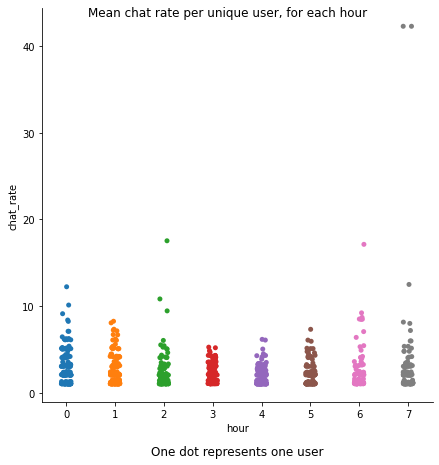

In [18]:
sns.catplot(x='hour',y='chat_rate', data=chat_rates, kind = 'strip',height=6)
plt.suptitle("Mean chat rate per unique user, for each hour",y=0.98)
plt.title("One dot represents one user",y=-0.15)

__Interpretation__: There were three chunks (at hours 2,6,7 respectively) where mean unique user chat rate was higher than anywhere else

In [19]:
isolated = chat_rates[chat_rates['hour']==7]
isolated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 1115 to 1239
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   hour        125 non-null    object             
 1   chunk       125 non-null    object             
 2   time_start  125 non-null    datetime64[ns, UTC]
 3   time_end    125 non-null    datetime64[ns, UTC]
 4   _id         125 non-null    object             
 5   num_chats   125 non-null    object             
 6   chat_rate   125 non-null    float64            
 7   elapsed     125 non-null    float64            
dtypes: datetime64[ns, UTC](2), float64(2), object(4)
memory usage: 8.8+ KB


In [20]:
mean_rates = chat_rates.groupby(['hour','chunk']).mean().reset_index()

In [21]:
mean_rates.sort_values('chat_rate', ascending=False).head(10)

,hour,chunk,chat_rate,elapsed
87,7,1,5.616447,105.146882
86,7,0,4.851385,105.146882
101,7,15,4.768575,100.659000
78,6,0,3.991713,103.504125
100,7,14,3.576431,100.659000
1,0,1,3.497183,111.750143
96,7,10,3.486104,109.648000
0,0,0,3.420562,111.750143
26,2,0,3.296661,92.380455
3,0,3,3.230044,114.060630


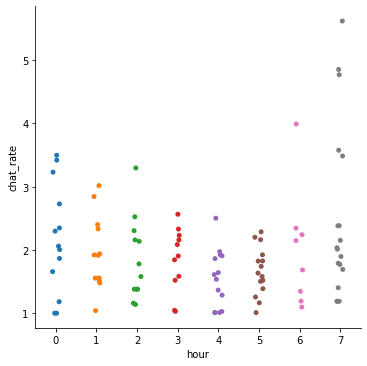

In [22]:
sns.catplot(x='hour',y='chat_rate',data=mean_rates, kind='strip')

## Per hour

In [23]:
def big_rate_finder(dataframe, x=2):
    '''
    Finds the overall chat rate per X minutes, regardless of chatter ID
    '''
    
    dataframe = dataframe.sort_values('created_at')
    seconds = dt.timedelta.total_seconds(dataframe.iloc[-1,0] - dataframe.iloc[0,0])
    messages = len(dataframe['body'])
    
    rate = (messages/seconds) * 60 * x
    
    return rate

In [24]:
hour_rates = {}
for i in range(len(hour_list)):
    rate = big_rate_finder(hour_list[i])
    hour_rates[i] = [rate]

In [25]:
hour_rates = pd.DataFrame(hour_rates).T.reset_index()
hour_rates.columns = ['hour','chat_per_2min']

Text(0.5, 1.0, 'Chat per 2min')

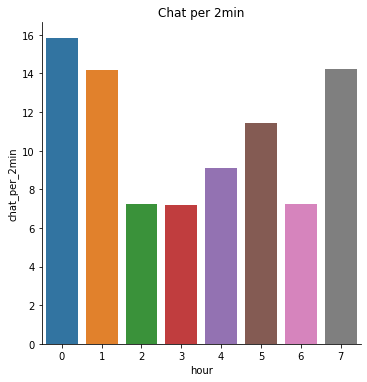

In [26]:
sns.catplot(x='hour',y='chat_per_2min',data=hour_rates, kind='bar')
plt.title("Chat per 2min")

__Interpretation__: Hours 0,1,7 had the most chat activity overall. 